## Helper Functions

In [1]:
def show_binary_image(image, title=None, size=(15,12)):
    '''Function to output binary thresholded image using matpltlib'''
    plt.figure(figsize=size)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if title != None:
        plt.title(title)
    plt.show()
    
def show_image(image, title=None, size=(15,12), cmap = None, axis= False):
    '''Function to show a rgb image'''
    plt.figure(figsize=size)

    if cmap == 'hot':
        plt.imshow(image, cmap='hot')
    elif cmap == 'gray':
            plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    if axis == False:
        plt.axis('off')
    if title != None:
        plt.title(title)
    plt.show()
    

## Feature Extraction Class

In [2]:
import numpy as np
import cv2
from skimage.feature import hog



class FeatureExtraction(object):
    
    def __init__(self, img, colour_space= 'YCrCb', orient_bins = 10, pixels_per_cell = 8, cells_per_block =2):
        
        self.orientation = orient_bins
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        #Convert the image pixels into the desired colour space
        if colour_space != 'RGB':
            if colour_space == 'HSV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif colour_space == 'LUV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif colour_space == 'HLS':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif colour_space == 'YUV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif colour_space == 'YCrCb':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: self.image = np.copy(img)
            
        #Get the dimensions of the image
        image_shape = self.image.shape
        self.height = image_shape[0]
        self.width = image_shape[1]
        self.depth = image_shape[2]
        
        #compute the hog features for the whole image over each channel
        self.hog_features = []
        for i in range(self.depth):
            
            hog_feat = hog(self.image[:,:,i], orientations = orient_bins, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                          cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, visualise=False,
                           feature_vector=False)
            self.hog_features.append(hog_feat)
            
        self.hog_features = np.asarray(self.hog_features)
        
    def colour_hist(self, img, nbins=32):  #bins_range=(0,256)
        #compute the histrogram of colour channels separatley
        channel0_hist = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))
        channel1_hist = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))
        channel2_hist = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))
        
        hist_features = np.concatenate((channel0_hist[0], channel1_hist[0], channel2_hist[0]))
        
        return hist_features
    
    def bin_spatial(self, img, size=(32,32)):
        colour1 = cv2.resize(img[:,:,0], size).ravel()
        colour2 = cv2.resize(img[:,:,1], size).ravel()
        colour3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((colour1, colour2, colour3))
    
    def hog(self, x, y, region_size):
        
        region = (region_size// self.pixels_per_cell) - 1
        
        location_x = x// self.pixels_per_cell
        location_y = y// self.pixels_per_cell
        
        #if (location_x + region) > self.hog_features.shape[2]:
        #    location_x = self.hog_features.shape[2] - region
            
        #if (location_y + region) > self.hog_features.shape[1]:
        #    location_y = self.hog_features.shape[1] - region
            
        return np.ravel(self.hog_features[:, location_y:location_y+region,  location_x:location_x+region, :, :, :])
            
            
        
    def get_features(self, x=0, y=0, region_size=64, spatial=True, colour_hist=True, hog_features=True):
        features = []       
        if spatial:
            spatial_features = self.bin_spatial(self.image[y:y+region_size, x:x+region_size, :])
            features.append(spatial_features)          
       
        if colour_hist:
            colour_hist_features = self.colour_hist(self.image[y:y+region_size, x:x+region_size, :])
            features.append(colour_hist_features)           
       
        if hog_features:
            hog_features = self.hog(x, y, region_size)
            features.append(hog_features)
            
        return np.concatenate(features)
            
        
            
        
        
            
       

## Read in data

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

##Read in the training data and make them into matrices

cars = []
non_cars = []
car_paths = glob.glob('../Data/vehicles/*/*.png')
non_car_paths = glob.glob('../Data/non-vehicles/*/*.png')
for path in car_paths:
    cars.append(mpimg.imread(path))
for path in non_car_paths:
    non_cars.append(mpimg.imread(path))
    
cars = np.asarray(cars)
non_cars = np.asarray(non_cars)
    

## Extract Features

In [4]:
car_features = []
non_car_features = []

for car in cars:
    car_features.append(FeatureExtraction(car).get_features())
for non_car in non_cars:
    non_car_features.append(FeatureExtraction(non_car).get_features())

car_features = np.asarray(car_features)
non_car_features = np.asarray(non_car_features)

/home/josh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [ ]:
##Save the extracted features to disk (dataset too large to fit into laptop memory)
print(car_features.shape)
print(non_car_features.shape)

np.savez_compressed('../Data/Extracted_features', car_features = car_features, non_car_features = non_car_features)

## Create Training and  Test Data set

In [ ]:
##Load the extracted features from disk
loaded = np.load('../Data/Extracted_features.npz')
car_features = loaded['car_features']
non_car_features = loaded['non_car_features']

In [5]:
# Combine and preprocess the training data set

from sklearn.preprocessing import StandardScaler
#note: train test split does both the shuffle and the split of the data
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, non_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)

#Normalise the datasets seperate to avoid any lookahead bias entering the data
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)



## Train Linear SVM

In [6]:
from sklearn import grid_search
from sklearn.svm import LinearSVC



parameters = {'C':np.logspace(-6, -2, 100)}

svc = LinearSVC()
clf = grid_search.GridSearchCV(svc, parameters)
clf.fit(scaled_X_train, y_train)
#svc.fit(scaled_X_train, y_train)

#print('Test Accuracy of SVM = ', svc.score(scaled_X_test, y_test))

/home/josh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/josh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-06,   1.09750e-06, ...,   9.11163e-03,   1.00000e-02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [8]:
print(clf.best_params_)

print('Test Accuracy of SVM = ', clf.score(scaled_X_test, y_test))

{'C': 0.00020092330025650479}
Test Accuracy of SVM =  0.994087837838


### Save Model

In [9]:
import pickle
#Save model to disk
filename= '../Models/linear_svm.sav'
pickle.dump(svc, open(filename, 'wb'))
#Save data normalisation routine
filename = '../Models/X_scaler.sav'
pickle.dump(X_scaler, open(filename, 'wb'))

### Load Model

In [ ]:
import pickle

filename = '../Models/linear_svm.sav'
clf = pickle.load(open(filename, 'rb'))
#print('Test Accuracy of SVM = ', svc.score(scaled_X_test, y_test))

filename = '../Models/X_scaler.sav'
X_scaler = pickle.load(open(filename, 'rb'))

## VechicleDetection

In [68]:
from collections import deque

from skimage.transform import resize
from scipy.ndimage.measurements import label

pix_per_cell = 8
cells_per_block =2
orient = 10

class VehicleDectection(object):
    
    def __init__(self, normalisation, classifier, initalise_frame):
        
        self.X_scaler = normalisation
        self.classifier = classifier
        self.image_shape = initalise_frame.shape
        self.previous_detections = deque(maxlen=20)
        
    def detect_vehicles(self, image, is_heatmap = False, is_windows= False):
        
        
        scales = np.array([ 1.0, 1.5, 2.0, 0.85])
        ytop = np.array([450, 350, 400, 400])
        ybottom = np.array([550, 600, 600, 450])
        xleft = np.array([450, 0, 0, 500])
        xright = np.array([1150,1280,1280,1100])
        
        detected_windows = np.empty([0, 4], dtype=np.int64)
        
        for scale, y_top, y_bottom, x_left, x_right in zip(scales, ytop, ybottom, xleft, xright):
            _, scaled_detections = self.search_windows_scale(image, scale, y_top, y_bottom, x_left, x_right, 64)
            
            detected_windows = np.append(detected_windows, scaled_detections, axis=0)
            
        self.previous_detections.append(detected_windows)
         
        #Draw the detected windows on the input image
        if is_windows or is_heatmap:
            img_det_win = self.draw_detections(image, detected_windows)
        
        
        ## Create the heatmap of the classfier detections
        heatmap_empty = np.zeros_like(image)[:,:,0]
        heatmap = self.add_heat(heatmap_empty, np.concatenate(np.array(self.previous_detections)))
        
        #Detect the number of cars in the heatmap
        labels = label(heatmap)
                
        #Draw the bounding boxes onto the image
        final_image = self.draw_labeled_bboxes( image, labels)
        
        if is_heatmap:
            return final_image, heatmap, img_det_win
        elif is_windows:
            return img_det_win
        else:
            return final_image
           
    def search_windows_scale(self, img, scale, y_start, y_stop, x_left, x_right ,window_size):

            original_image = np.copy(img)

            detections = np.empty([0, 4], dtype=np.int)

            #Restrict the image the search area
            image = img[y_start:y_stop, x_left:x_right, :]
            image = image.astype(np.float32)/255
            

            imshape =  image.shape
            img_scaled = cv2.resize(image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            imshape_scaled = img_scaled.shape
            extraction = FeatureExtraction(img_scaled)

            # Define blocks and steps to transverse
            nxblocks = (imshape_scaled[1] // pix_per_cell) - cells_per_block + 1
            nyblocks = (imshape_scaled[0] // pix_per_cell) - cells_per_block + 1
            nfeat_per_block = orient*cells_per_block**2


            nblocks_per_window = (window_size // pix_per_cell) - cells_per_block + 1
            cells_per_step = 3 #this is used instead of the overlap

            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

            
            for xb in range(nxsteps):
                for yb in range(nysteps):

                    y_pos = yb*cells_per_step
                    x_pos = xb*cells_per_step

                    xleft = x_pos*pix_per_cell
                    ytop = y_pos*pix_per_cell

                    features = extraction.get_features(xleft, ytop).reshape(1,-1)
                    test_features = self.X_scaler.transform(features)
                    test_prediction = self.classifier.predict(test_features)

                    if test_prediction == 1:

                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window_size*scale)
                        window = [[xbox_left, ytop_draw+y_start, xbox_left+win_draw, ytop_draw+win_draw+y_start]]
                        detections = np.append(detections , window, axis=0)
                        cv2.rectangle(original_image, (xbox_left + x_left, ytop_draw+y_start), (xbox_left+win_draw + x_left, ytop_draw+win_draw+y_start), (0,0,255),6)


            return original_image, detections
        
    def draw_detections(self, image, windows):
        image_copy = np.copy(image)

        for window in windows:
            cv2.rectangle(image_copy, (window[0], window[1]), (window[2], window[3]), (0,0,255), 6)
            
        return image_copy
    
    def add_heat(self, heatmap, windows, threshold = 15):
        
        for window in windows:
            heatmap[window[1]:window[3], window[0]:window[2]] += 1
            
        
        return self.apply_threshold(heatmap, min(threshold,len(self.previous_detections) ))
    
    def apply_threshold(self, heatmap, threshold):
        
        heatmap[heatmap <= threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        
        image_output = np.copy(img)
        
        for car_number in range(1, labels[1]+1):
            #find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            
            #Identify x and y values of those pixels 
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            #define the bounding box based on min/max x and y
            
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            #Draw the bounding box on the image
            cv2.rectangle(image_output, bbox[0], bbox[1], (0,0,255), 6)
            
        return image_output
            
                                     
                                     


        
    


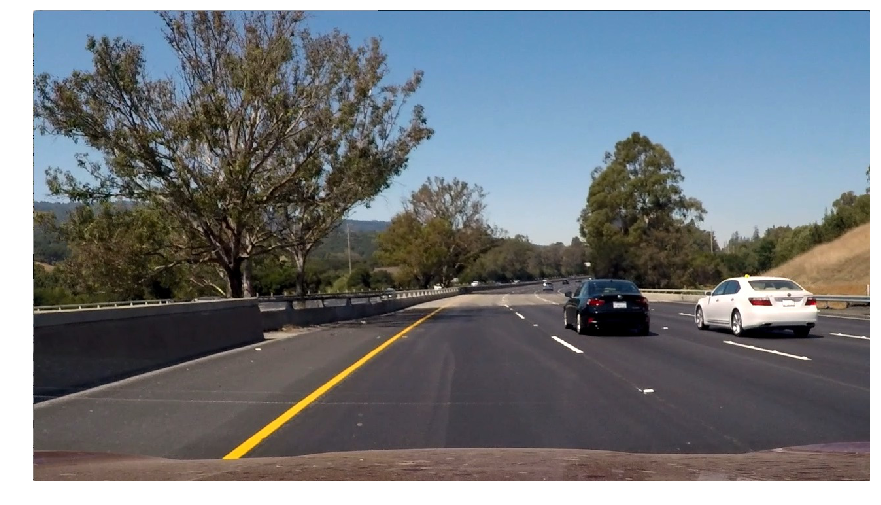

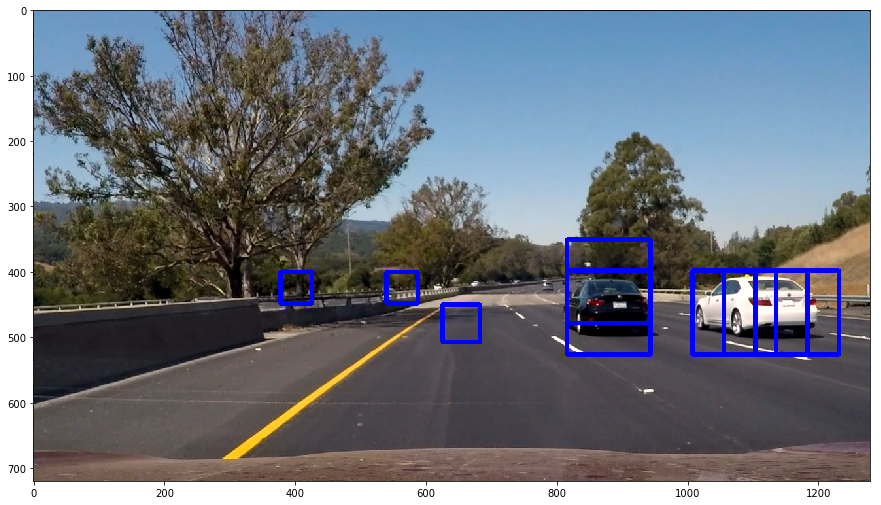

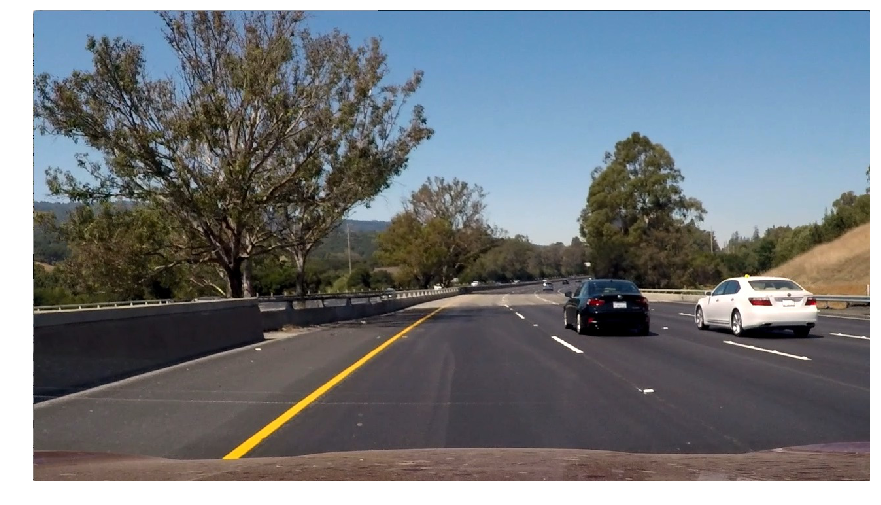

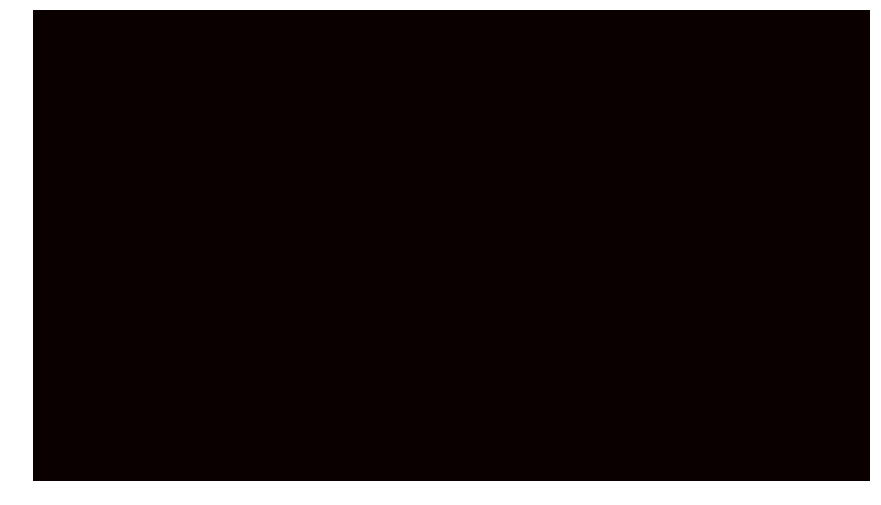

In [54]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

test_image = mpimg.imread('../test_images/test6.jpg')

detector = VehicleDectection(X_scaler, clf, test_image)

detected_img, heatmap, windows = detector.detect_vehicles(test_image, is_heatmap=True)


show_image(test_image)
show_image(windows, axis=True)
show_image(detected_img)
show_image(heatmap, cmap='hot')




## Apply to video data

In [61]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [70]:
test_image = mpimg.imread('../test_images/test6.jpg')
detector = VehicleDectection(X_scaler, clf, test_image)

video_output = '../output_videos/project_video.mp4'
clip1 = VideoFileClip('../project_video.mp4')

white_clip = clip1.fl_image(detector.detect_vehicles)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video.mp4
[MoviePy] Writing video ../output_videos/project_video.mp4



100%|█████████▉| 1260/1261 [09:28<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video.mp4 

CPU times: user 34min 23s, sys: 13.7 s, total: 34min 37s
Wall time: 9min 29s
